## Exploratory Data Analysis

In [1]:
## Import Packages Necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk
from nltk.stem.porter import PorterStemmer
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix,roc_auc_score,roc_curve

## Import Functions from pandas module.
import sys
sys.path.insert(1, './../../Analysis_Functions_For_Pandas')
from functions import (preview_data,
                       get_missing_counts,
                       get_value_counts,
                       get_unique_column_count,
                       get_datetimes,
                       plot_roc_curves)  

In [2]:
## Load the Data
df = pd.read_csv('.\..\Data\Finalized_DataFrame_All_Data_2_Anonymized.csv')

In [3]:
## Replace Punctuation
df['Tweet_Cleaned'] = df['Tweet'].str.replace("[^a-zA-Z#]"," ")

In [4]:
## Further clean tweet by splitting words. 
df["clean_tweet"] = df['Tweet_Cleaned'].apply(lambda x: " ".join([w for w in x.split() if len(w) >3]))

In [5]:
## Simplify dataframe
simp = df[['Team','Result','clean_tweet']]

In [6]:
## Preview sample of 3 dataframes. 
simp.sample(3)

,Team,Result,clean_tweet
19725,Tottenham,0,SpursOfficial Most Spurzy thing ever Lose beat...
62196,Arsenal,0,Arsenal trust boune back https izNbgkRvsq
306184,Arsenal,1,Brock many moves arsenal doesn those moves wat...


In [7]:
## Tokenize the tweets. 
tokenized_tweet = simp['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [JackAFC, LUHG, Thegameis, Because, arsenal, h...
1      [arsenal, lady, werde, einfach, immer, schwach]
2    [games, finals, games, either, want, European,...
3    [Arsenal, HectorBellerin, VAMOS, HectorBelleri...
4    [Cristiano, Come, Arsenal, many, assists, cros...
Name: clean_tweet, dtype: object

In [8]:
## Stem words in tweet (takes 3-5 minutes to run)
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(word) for word in x])

In [9]:
## Preview tweet
tokenized_tweet.head()

0    [jackafc, luhg, thegamei, becaus, arsen, have,...
1         [arsen, ladi, werd, einfach, immer, schwach]
2    [game, final, game, either, want, european, tr...
3    [arsen, hectorbellerin, vamo, hectorbellerin, ...
4    [cristiano, come, arsen, mani, assist, cross, ...
Name: clean_tweet, dtype: object

In [10]:
## Combine words into single sentence:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
simp['clean_tweet'] = tokenized_tweet
simp.head()

C:\Users\benja\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Team,Result,clean_tweet
0,Arsenal,1,jackafc luhg thegamei becaus arsen have self a...
1,Arsenal,1,arsen ladi werd einfach immer schwach
2,Arsenal,1,game final game either want european trip back...
3,Arsenal,1,arsen hectorbellerin vamo hectorbellerin even ...
4,Arsenal,1,cristiano come arsen mani assist cross with fi...


#### 1) All words

In [11]:
## Exploring all the Words 
all_words = " ".join([sentence for sentence in simp['clean_tweet']])
wordcloud = WordCloud(width =800, height = 500,
                      random_state = 42, max_font_size=100).generate(all_words)

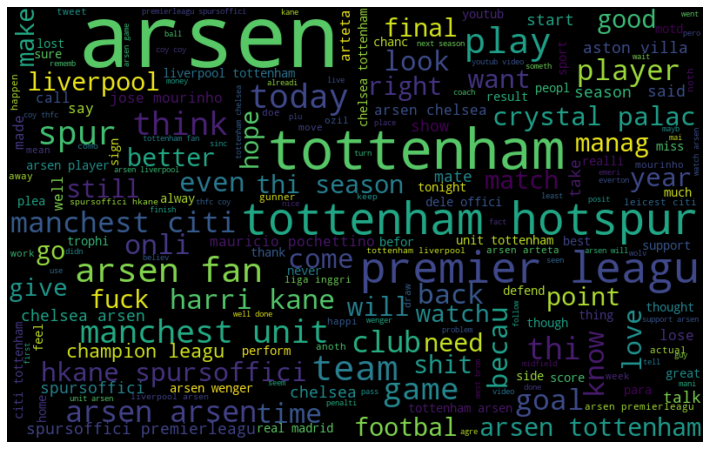

<Figure size 432x288 with 0 Axes>

In [12]:
## Creating visualizawtion  for most found words 
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation ='bilinear')
plt.axis('off')
plt.show()
plt.savefig('.\..\images\itokenize_wordcloud.png')

#### 2) Words when teams win.

In [13]:
## frequent words when there are wins
all_words_wins = " ".join([sentence for sentence in simp['clean_tweet'][simp['Result'] == 1]])

wordcloud_wins = WordCloud(width =800, height = 500,
                      random_state = 42, max_font_size=100).generate(all_words_wins)

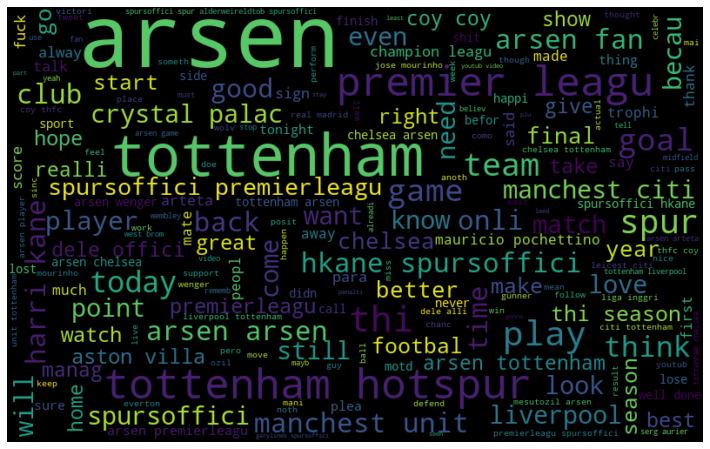

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_wins, interpolation ='bilinear')
plt.axis('off')
plt.show()
plt.savefig('.\..\images\itokenize_wordcloud_wins.png')

#### 3) Words when team ties or loses

In [15]:
## frequent words when there are wins
all_words_losstie = " ".join([sentence for sentence in simp['clean_tweet'][simp['Result'] == 0]])

wordcloud_losstie = WordCloud(width =800, height = 500,
                      random_state = 42, max_font_size=100).generate(all_words_losstie)

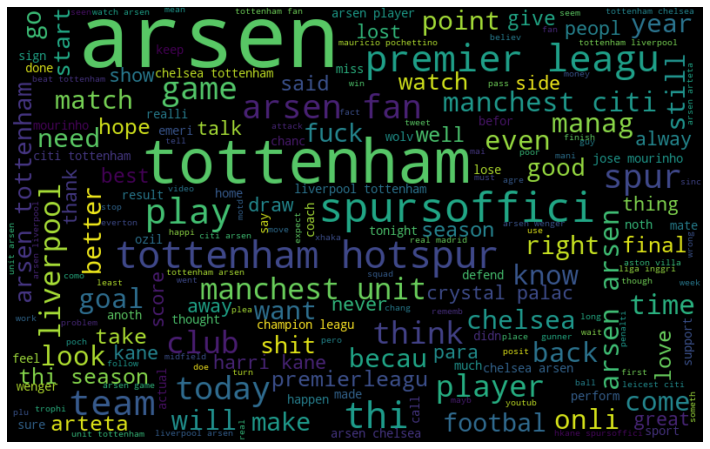

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud_losstie, interpolation ='bilinear')
plt.axis('off')
plt.show()
plt.savefig('.\..\images\itokenize_wordcloud_losstie.png')

In [17]:
# Getting Most Popular Hashtags
def hashtag_extract(tweets):
    hashtags = []
    #loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [18]:
# Extract hashtags from positive results
ht_positive = hashtag_extract(df['clean_tweet'][df['Result']==1])

# Extract hashtags negative results 
ht_negative = hashtag_extract(df['clean_tweet'][df['Result']==0])

In [19]:
## Unnest list 
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [20]:
## Get distribution of hashtags when team is winning. 
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag':list(freq.keys()),
                  'Count':list(freq.values())})
d.head()

,Hashtag,Count
0,PremierLeague,2717
1,Arsenal,3969
2,arsenal,1123
3,BarracasCentral,2
4,Velez,17


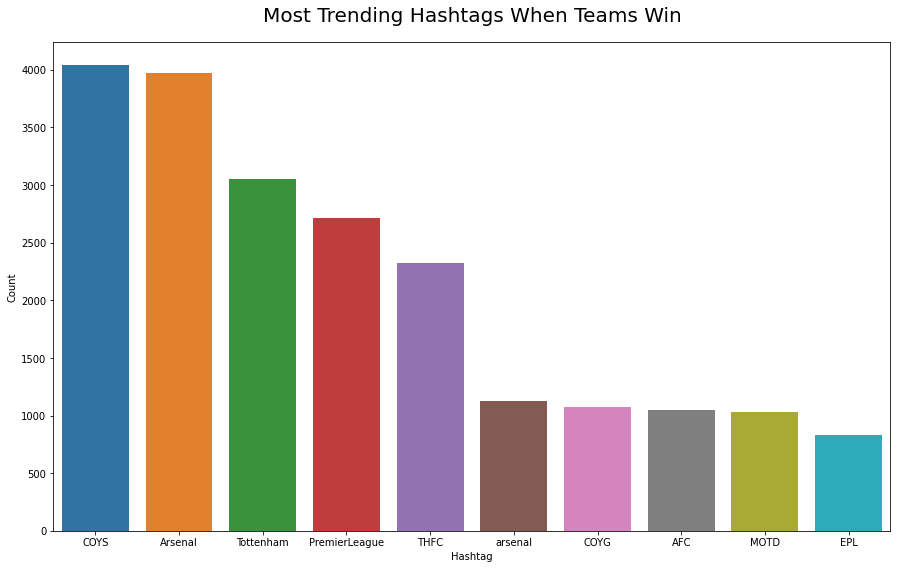

In [21]:
## Select top 10 hashtags 
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data =d, x ='Hashtag', y ='Count')
plt.title('Most Trending Hashtags When Teams Win', pad= 20, fontsize = 20)
plt.show()

In [22]:
freq_neg = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag':list(freq_neg.keys()),
                  'Count':list(freq_neg.values())})
d.head()

,Hashtag,Count
0,Manchestercity,2
1,Liverpool,455
2,Chelsea,426
3,Arsenal,3602
4,Tottenham,2332


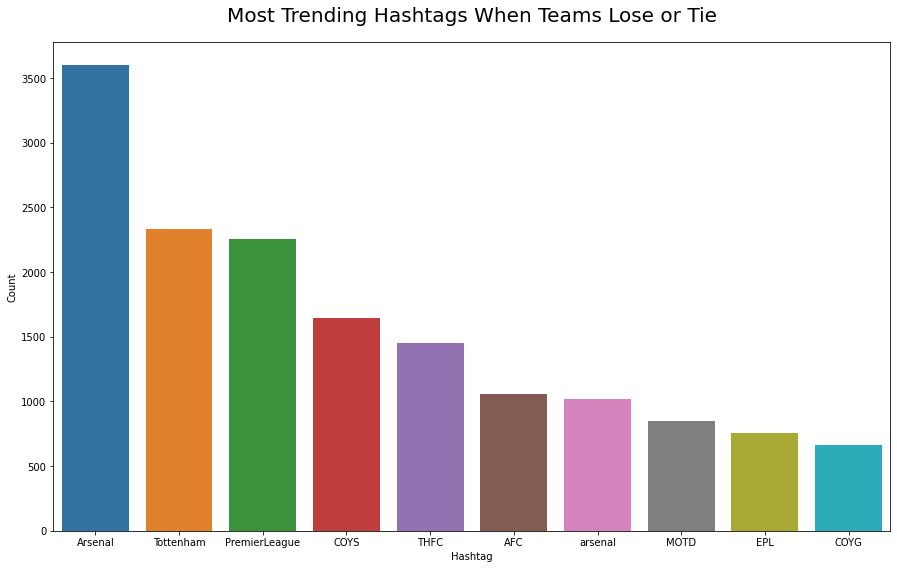

In [23]:
d_neg = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data =d_neg, x ='Hashtag', y ='Count')
plt.title('Most Trending Hashtags When Teams Lose or Tie', pad= 20, fontsize = 20)
plt.show()

### Input Split

In [24]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words = 'english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [25]:
#bow[0]

In [26]:
#bow[0].toarray()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(bow, df['Result'], test_size = 0.25, random_state = 42)

### Model Training 

In [28]:
# training model
model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\benja\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [29]:
# testing
pred = model.predict(X_test)
f1_score(y_test, pred)

0.6212208229068384

In [30]:
accuracy_score(y_test,pred)

0.6007135135135135

In [31]:
len(df['Result'])

370000

In [32]:
df['Result'].value_counts()

1    189000
0    181000
Name: Result, dtype: int64

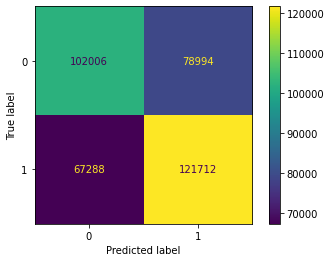

In [33]:
plot_confusion_matrix(model, bow, df['Result'],values_format = '.0f')
plt.show()

C:\Users\benja\Anaconda3\envs\py37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
./../../Analysis_Functions_For_Pandas\functions.py:155: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')
./../../Analysis_Functions_For_Pandas\functions.py:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (

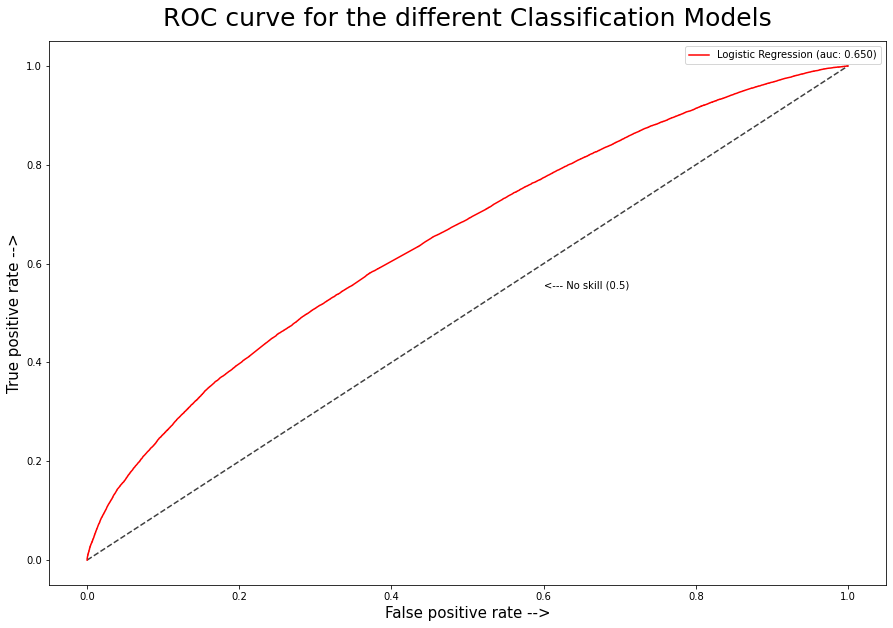

In [34]:
plot_roc_curves(['Logistic Regression'],[model],X_train,y_train,X_test,y_test,roc_curve,roc_auc_score)

In [35]:
import spacy
import scattertext
nlp = spacy.load('en_core_web_sm')

ModuleNotFoundError: No module named 'scattertext'